In [2]:
from sklearn.datasets import fetch_20newsgroups

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

import spacy
import en_core_web_sm
import string

from wordcloud import WordCloud

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from gensim import corpora, models

from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
dataset, target = fetch_20newsgroups(shuffle=True, random_state=123,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)

In [3]:
topics=['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
df = pd.DataFrame(list(zip(dataset, target)),
               columns =['text', 'topic'])

In [5]:
df.head()

,text,topic
0,A quick query for Powerbook gurus:\nTom Spearm...,4
1,From article <1993Apr18.000152.2339@gnv.ifas.u...,16
2,"\nSteve, take a look at what you are saying. ...",13
3,I have a routine that changes the color (RGB) ...,1
4,\nI sometimes wonder if Kekule's dream wasn't ...,13


In [6]:
nlp = en_core_web_sm.load()

def convert_emojis(text):
        for emot in UNICODE_EMO:
            text = text.replace(emot, " ")
        return text
    
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', " ", text)
    return text

def expand_contractions(text):
    contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                 "can't": "cannot","can't've": "cannot have",
                 "'cause": "because","could've": "could have","couldn't": "could not",
                 "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                 "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                 "hasn't": "has not","haven't": "have not","he'd": "he would",
                 "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                 "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                 "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                 "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                 "it'd": "it would","it'd've": "it would have","it'll": "it will",
                 "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                 "mayn't": "may not","might've": "might have","mightn't": "might not", 
                 "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                 "mustn't've": "must not have", "needn't": "need not",
                 "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                 "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                 "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                 "she'll": "she will", "she'll've": "she will have","should've": "should have",
                 "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                 "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                 "there'd've": "there would have", "they'd": "they would",
                 "they'd've": "they would have","they'll": "they will",
                 "they'll've": "they will have", "they're": "they are","they've": "they have",
                 "to've": "to have","wasn't": "was not","we'd": "we would",
                 "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                 "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                 "what'll've": "what will have","what're": "what are", "what've": "what have",
                 "when've": "when have","where'd": "where did", "where've": "where have",
                 "who'll": "who will","who'll've": "who will have","who've": "who have",
                 "why've": "why have","will've": "will have","won't": "will not",
                 "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                 "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                 "y'all'd've": "you all would have","y'all're": "you all are",
                 "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                 "you'll": "you will","you'll've": "you will have", "you're": "you are",
                 "you've": "you have"}

    # Regular expression for finding contractions
    contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text) 

def remove_short_words(input_txt):
    return ' '.join([w for w in input_txt.split() if len(w)>3])

def lemmatization(input_txt):
    doc = nlp(input_txt)
    spacy_words = [t.lemma_ for t in doc if ((t.text in nlp.vocab) and (not t.is_stop) and (t.pos_ in ["ADJ","NOUN","VERB","PROPN"])  )]
    sentence=" ".join(spacy_words)
    return sentence

def remove_email_address(input_text):
    return re.sub("\S*@\S*\s?",' ',input_text)

def preprocess(data):
    data=str(data).lower()
    data=convert_emoticons(data)
    data=convert_emojis(data)
    data=remove_email_address(data)
    data=expand_contractions(data)    
    data=re.sub('[^A-Za-z0-9]+', ' ',data)
    data=re.sub('\w*\d\w*','', data)
    data=re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", data)
    data=re.sub("[^a-zA-Z#]", " ",data)
    data=re.sub(' +',' ',data)
    data=lemmatization(data)
    data=remove_short_words(data)
    return data
def find_keywords(docs):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(docs)
    keywords=[]
    for vector in vectors:
        names = vectorizer.get_feature_names()
        data = vector.T.todense().tolist()
        tmp = pd.DataFrame(data, index=names,columns=["tfidf"])
        tmp=tmp.sort_values(by=["tfidf"],ascending=False)
        words=tmp.index[:15].tolist()
        keywords.append(words)
    return keywords

In [7]:
df["clean_text"]=df.text.apply(lambda x: preprocess(x))

In [8]:
df.head()

,text,topic,clean_text
0,A quick query for Powerbook gurus:\nTom Spearm...,4,quick query powerbook gurus spearman post alte...
1,From article <1993Apr18.000152.2339@gnv.ifas.u...,16,article irrational fool rkba plenty people sup...
2,"\nSteve, take a look at what you are saying. ...",13,steve look construvtive word constructive wast...
3,I have a routine that changes the color (RGB) ...,1,routine change color attribute adapter work mo...
4,\nI sometimes wonder if Kekule's dream wasn't ...,13,wonder kekule dream influence aromatic solvent...


In [9]:
topics_docs=df.groupby("topic",as_index=False)
topics_docs_array=[]
for topic, docs in topics_docs:
    clean_docs_array=[]
    for i, row in docs.iterrows():
        text = row['clean_text']
        clean_docs_array.append(text)
    topics_docs_array.append(" ".join(clean_docs_array))
topics_keywords=find_keywords(topics_docs_array)

In [10]:
df_topics=pd.DataFrame({"topic":topics,"keywords":topics_keywords})

In [11]:
df_topics

,topic,keywords
0,alt.atheism,"[atheism, atheist, people, religion, think, is..."
1,comp.graphics,"[image, jpeg, file, graphic, format, program, ..."
2,comp.os.ms-windows.misc,"[window, file, nrhj, problem, font, driver, wi..."
3,comp.sys.ibm.pc.hardware,"[scsi, drive, controller, card, disk, system, ..."
4,comp.sys.mac.hardware,"[scsi, apple, drive, problem, nubus, quadra, k..."
5,comp.windows.x,"[widget, motif, window, file, program, server,..."
6,misc.forsale,"[sale, good, offer, include, shipping, sell, p..."
7,rec.autos,"[good, engine, drive, brake, think, know, time..."
8,rec.motorcycles,"[bike, ride, motorcycle, helmet, know, think, ..."
9,rec.sport.baseball,"[year, team, game, good, player, baseball, thi..."


In [12]:
df.head()

,text,topic,clean_text
0,A quick query for Powerbook gurus:\nTom Spearm...,4,quick query powerbook gurus spearman post alte...
1,From article <1993Apr18.000152.2339@gnv.ifas.u...,16,article irrational fool rkba plenty people sup...
2,"\nSteve, take a look at what you are saying. ...",13,steve look construvtive word constructive wast...
3,I have a routine that changes the color (RGB) ...,1,routine change color attribute adapter work mo...
4,\nI sometimes wonder if Kekule's dream wasn't ...,13,wonder kekule dream influence aromatic solvent...


In [13]:
tokens=[x.split() for x in df.clean_text.values]

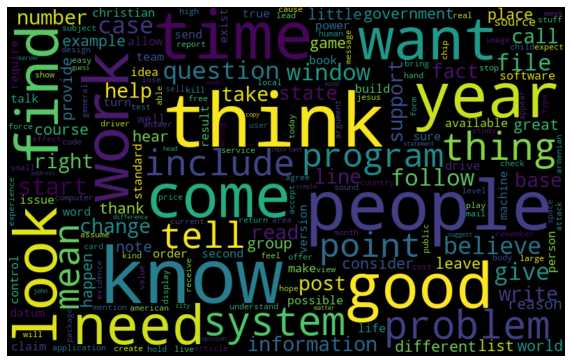

In [14]:
all_words = [item for sublist in tokens for item in sublist]

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(all_words))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

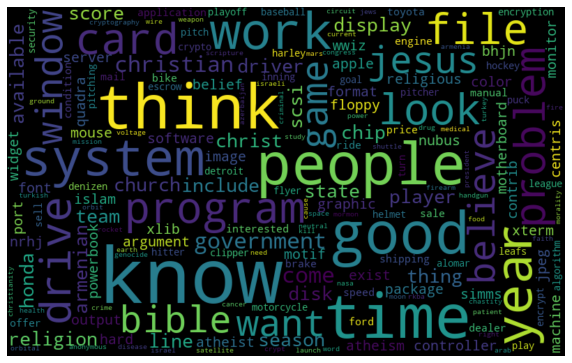

In [15]:
all_words = [item for sublist in df_topics.keywords.values for item in sublist]

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(all_words))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [16]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=10, no_above=0.2)
corpus = [dictionary_LDA.doc2bow(doc) for doc in tokens]

In [22]:
lda_scores=[]
lda_models=[]
for i in range(6,21):
    lda_model = models.LdaModel(corpus, num_topics=i,id2word=dictionary_LDA,alpha="auto",eta="auto",passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary_LDA, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    lda_scores.append(coherence_lda)
    lda_models.append(lda_model)


Coherence Score:  0.5219504313558119

Coherence Score:  0.5161445095847466

Coherence Score:  0.5648351376435203

Coherence Score:  0.5832172161944087

Coherence Score:  0.594592530550607

Coherence Score:  0.5624867733159418

Coherence Score:  0.5550535534781522

Coherence Score:  0.573095069272723

Coherence Score:  0.5892873287900888

Coherence Score:  0.589423805771054

Coherence Score:  0.5681532340065458

Coherence Score:  0.6126544086232909

Coherence Score:  0.6007197447622532

Coherence Score:  0.5627346428549115

Coherence Score:  0.5791124190099003


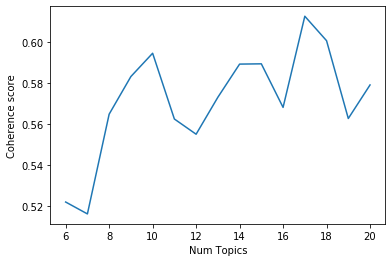

In [24]:
import matplotlib.pyplot as plt
x = range(6, 21)
plt.plot(x, lda_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [52]:
lda_model=lda_models[9]
lda_model.save("lda-model.model")

In [53]:
lda_model = models.LdaModel.load("lda-model.model")
for i,topic in lda_model.show_topics(formatted=True, num_topics=20, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.027*"chip" + 0.024*"encryption" + 0.021*"government" + 0.018*"clipper" + 0.016*"security" + 0.015*"system" + 0.013*"phone" + 0.012*"agency" + 0.012*"technology" + 0.011*"public"

1: 0.020*"system" + 0.020*"ground" + 0.015*"internet" + 0.011*"wire" + 0.010*"current" + 0.010*"circuit" + 0.008*"field" + 0.008*"require" + 0.008*"company" + 0.007*"electronic"

2: 0.022*"good" + 0.022*"time" + 0.020*"thing" + 0.014*"look" + 0.012*"want" + 0.011*"problem" + 0.010*"well" + 0.010*"people" + 0.009*"point" + 0.008*"find"

3: 0.014*"people" + 0.013*"believe" + 0.010*"jesus" + 0.009*"christian" + 0.008*"church" + 0.007*"word" + 0.007*"thing" + 0.007*"mean" + 0.007*"question" + 0.007*"claim"

4: 0.020*"state" + 0.019*"right" + 0.013*"people" + 0.013*"government" + 0.011*"weapon" + 0.009*"crime" + 0.009*"firearm" + 0.008*"control" + 0.008*"group" + 0.008*"issue"

5: 0.018*"sell" + 0.016*"sale" + 0.016*"good" + 0.014*"book" + 0.013*"price" + 0.013*"offer" + 0.011*"water" + 0.011*"condition" + 0.0

In [54]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary_LDA, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.589423805771054


In [55]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [56]:
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.082057  0.004637       1        1  14.138704
10     0.161962  0.085235       2        1  11.031721
2     -0.001566 -0.134763       3        1   9.729538
12    -0.122927 -0.092669       4        1   8.930348
4     -0.175748  0.132627       5        1   7.511234
8     -0.039946  0.135379       6        1   6.421668
6      0.193214 -0.098123       7        1   6.066697
9     -0.157967 -0.211107       8        1   5.914233
7     -0.032862  0.015528       9        1   5.325582
14     0.225396 -0.016442      10        1   4.685370
13    -0.247713  0.083123      11        1   4.434492
5      0.002756 -0.218312      12        1   4.285385
0      0.008495  0.177302      13        1   4.142793
11     0.178623  0.008768      14        1   3.932164
1      0.090341  0.128815      15        1   3.450070, topic_info=        Term         Freq        Total Category  logprob  loglift
561     file  2447.000000  2447.000000  Default  30.0000  30.0000
858   window  1808.000000  1808.000000  Default  29.0000  29.0000
613    drive  1680.000000  1680.000000  Default  28.0000  28.0000
251     game  1276.000000  1276.000000  Default  27.0000  27.0000
365     team  1064.000000  1064.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
390    power   119.134927  1111.961932  Topic15  -5.0724   1.1332
579  general   106.296215   754.109454  Topic15  -5.1864   1.4075
31     cause   102.630858   774.471650  Topic15  -5.2215   1.3457
205     note   100.912371   957.369468  Topic15  -5.2384   1.1168
882  example   100.690830   957.661028  Topic15  -5.2406   1.1143

[1026 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3114      5  0.970284  abortion
1870      2  0.297478    access
1870      3  0.003563    access
1870      5  0.055220    access
1870      6  0.040970    access
...     ...       ...       ...
550       8  0.234884     young
550       9  0.087242     young
550      11  0.033555     young
550      12  0.003355     young
550      14  0.020133     young

[3274 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 11, 3, 13, 5, 9, 7, 10, 8, 15, 14, 6, 1, 12, 2])